-------------------------------
-------------------------------
# Proyecto 1 - IA (CC3085)
* DULCE AMBROSIO - 231143
* DANIEL CHET - 231177
* GADIEL OCAÑA - 231270

-------------------------------
-------------------------------

······· Task 1.1 - Discretizacion del Mundo ·······


Convierte la imagen .bmp en una matriz discreta (grid) donde cada celda representa una baldosa del mapa.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Se carga la imagen
img = Image.open("Prueba Lab1.bmp")
img = img.convert("RGB")
img_array = np.array(img)

print("Dimensiones:", img_array.shape)

Dimensiones: (582, 582, 3)


In [8]:
# Se define el tamaño de baldosa (tile), para no procesar
# pixel por pixel

TILE_SIZE = 10

In [9]:
# Se crear el grid discreto
rows = img_array.shape[0] 
cols = img_array.shape[1] 

grid = np.zeros((rows, cols), dtype=object)

print("Grid size:", grid.shape)

Grid size: (582, 582)


In [10]:
# Se clasifica cada baldosa, tomando los pixeles,
# calculando el promedio RGB y clasificando según el color:
#   - Negro: pared
#   - Rojo: inicio
#   - Verde: meta
#   - Blanco: libre

start = None
goals = []

for i in range(rows):
    for j in range(cols):
        
        tile = img_array[
            i*TILE_SIZE:(i+1)* TILE_SIZE,
            j*TILE_SIZE:(j+1)* TILE_SIZE
        ]
        
        avg_color = tile.mean(axis=(0,1))
        r, g, b = avg_color
        
        # Negro - pared
        if r < 50 and g < 50 and b < 50:
            grid[i][j] = "WALL"
        
        # Rojo - inicio
        elif r > 200 and g < 50 and b < 50:
            grid[i][j] = "START"
            start = (i, j)
        
        # Verde - meta
        elif g > 200 and r < 50 and b < 50:
            grid[i][j] = "GOAL"
            goals.append((i, j))
        
        # Blanco - libre
        else:
            grid[i][j] = "FREE"


C:\Users\dulce\AppData\Local\Temp\ipykernel_5084\4184305021.py:19: RuntimeWarning: Mean of empty slice.
  avg_color = tile.mean(axis=(0,1))
c:\Users\dulce\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [11]:
# Se verifica que haya detectado el inicio y la meta

print("Start:", start)
print("Goals:", goals)

Start: (52, 50)
Goals: [(5, 4), (5, 5), (5, 6), (6, 4), (6, 5), (6, 6), (7, 5), (7, 6)]


······· Task 1.2 - Búsqueda ·······


Se implementa el framework de búsqueda, para construir una clase abstracta que represente el problema usando POO y luego implementar los  agoritmos BFS y DFS usando Graph Search, para evitar el backtracking.

In [ ]:
# Se crea la clase abstracta del problema 
from abc import ABC, abstractmethod

class SearchProblem(ABC):
    
    @abstractmethod
    def getStartState(self):
        pass
    
    @abstractmethod
    def isGoalState(self, state):
        pass
    
    @abstractmethod
    def getSuccessors(self, state):
        pass

In [13]:
# Se crea la clase para implementar el MazeProblem 

class MazeProblem(SearchProblem):
    
    def __init__(self, grid, start, goals):
        self.grid = grid
        self.start = start
        self.goals = goals
        self.rows = len(grid)
        self.cols = len(grid[0])

    # Devuelve el estado inicial
    def getStartState(self):
        return self.start
    
    # Devuelve True si el estado es un estado meta (verifica)
    def isGoalState(self, state):
        return state in self.goals
    
    # Genera movimientos validos
    # Verifica que no se salga del grid y que no sea una pared
    def getSuccessors(self, state):
        
        successors = []
        
        i, j = state
        
        directions = [
            (1, 0),   # abajo
            (-1, 0),  # arriba
            (0, 1),   # derecha
            (0, -1)   # izquierda
        ]
        
        for di, dj in directions:
            ni, nj = i + di, j + dj
            
            if 0 <= ni < self.rows and 0 <= nj < self.cols:
                if self.grid[ni][nj] != "WALL":
                    successors.append(((ni, nj), 1))
        
        return successors

        # Devuelve el nuevo estado y el costo (en este caso, costo uniforme de 1 por movimiento)


In [14]:
# Se implementa el BFS para encontrar el camino con menor
# número de pasos ignorando costos

# Se visitan los niveles por profundidad
# Garantiza el menor número de pasos

from collections import deque

def bfs(problem):
    
    start = problem.getStartState()
    
    queue = deque()
    queue.append((start, []))
    
    visited = set() # Se usa para convertir el Tree Search en Graph Search
    
    while queue:
        
        state, path = queue.popleft()
        
        if problem.isGoalState(state):
            return path + [state]
        
        if state not in visited:
            visited.add(state)
            
            for successor, cost in problem.getSuccessors(state):
                queue.append((successor, path + [state]))
    
    return None


In [15]:
# Se implementan los DFS, para explorar
# caminos profundamente antes de retroceder

def dfs(problem):
    
    start = problem.getStartState()
    
    stack = [(start, [])]
    visited = set()
    
    while stack:
        
        state, path = stack.pop()
        
        if problem.isGoalState(state):
            return path + [state]
        
        if state not in visited:
            visited.add(state)
            
            for successor, cost in problem.getSuccessors(state):
                stack.append((successor, path + [state]))
    
    return None


In [16]:
# Se prueban los BFS y DFS

problem = MazeProblem(grid, start, goals)

bfs_path = bfs(problem)
dfs_path = dfs(problem)

print("BFS path length:", len(bfs_path))
print("DFS path length:", len(dfs_path))


BFS path length: 95
DFS path length: 893


In [17]:
# Se muestra la ruta encontrada sobre la matriz discreta de manera gráfica
# Se crea una matriz numerica 
#   - 0 para paredes
#   - 1 para espacios libres
#  - 2 para la ruta encontrada

def visualize_path(grid, path):
    
    visual = np.zeros((len(grid), len(grid[0])))
    
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == "WALL":
                visual[i][j] = 0
            else:
                visual[i][j] = 1
    
    for (i,j) in path:
        visual[i][j] = 2
    
    plt.imshow(visual)
    plt.title("Path Found")
    plt.colorbar()
    plt.show()


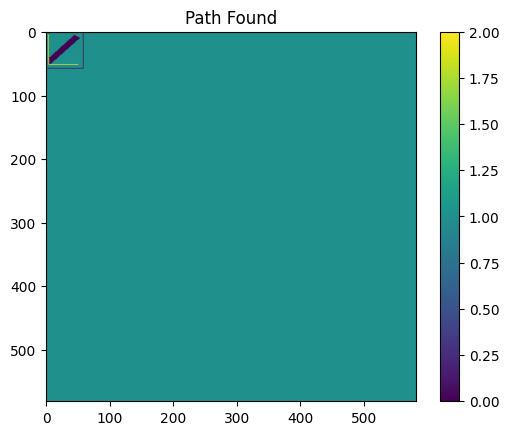

In [18]:
# Se prueba 

visualize_path(grid, bfs_path)

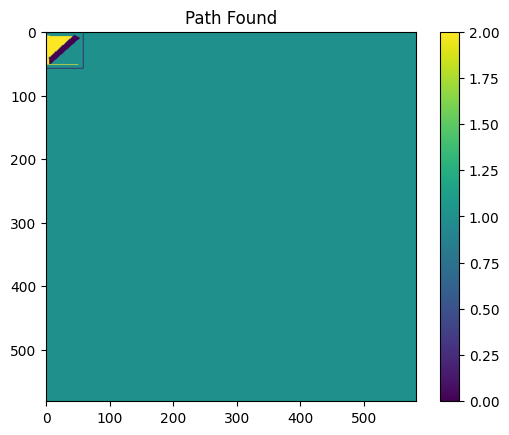

In [19]:
visualize_path(grid, dfs_path)